# Observable vs. Unobservable States: Monocamera System
This example demonstrates the difference between observable and unobservable states using a simplified monocamera system. The system models a vehicle flying over terrain with two states: groundspeed and height. A single sensor—a monocamera—provides optic flow measurements, which correspond to the ratio of groundspeed to height.

The dynamics are trivial: the system states are directly controlled by sinusoidal inputs that activate one axis at a time. However, the nonlinear measurement function introduces a critical observability challenge: the optic flow alone cannot distinguish between certain combinations of height and speed. This makes the system only partially observable, and highlights the importance of understanding observability in sensor-driven estimation.

We will use this setup to visualize how the lack of full observability impacts state estimation and uncertainty over time.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykal.control_system.system import System
from numpy.typing import NDArray
from typing import Callable

## Monocamera

def sinusoidal_control_input_with_params(
    amplitude: float = 10.0,
    frequency: float = 1.0,
    t_switch: float = 5.0
) -> Callable[[float], NDArray]:
    omega = 2 * np.pi * frequency

    def control_input(t: float) -> NDArray:
        if t < t_switch:
            return np.array([[amplitude * np.sin(omega * t), 0.0]]).T
        else:
            return np.array([[0.0, amplitude * np.sin(omega * t)]]).T

    return control_input

def camera_dynamics(u:NDArray) -> NDArray:  # no system dynamics, just passthrough
    return u

def optic_flow_sensor(x:NDArray) -> NDArray: #
    groundspeed, height = x[0][0], x[1][0]
    if height <=  0:
        raise ValueError(f"height cannot be less than or equal to 0, got {height}")
    optic_flow = np.array([[groundspeed/height]])
    return optic_flow


state_names = ["groundspeed", "height"]
measurement_names = ["optic_flow"]
sys = System(
f= camera_dynamics,
h = optic_flow_sensor,
u = sinusoidal_control_input_with_params(),
Q = System.zero_Q(state_names=state_names),
R = System.zero_R(measurement_names=measurement_names),
state_names=state_names,
measurement_names=measurement_names,
input_names=['horizontal_force','vertical_force'],
 system_type="cti")


## Simulating the Monocamera System

In this example, we simulate the monocamera system starting from an initial state with a fixed height and zero groundspeed. The sinusoidal control input drives the system, first horizontally and then vertically, revealing how the states evolve over time. The amplitude and frequency of the control input, and even the time at which it switches from the horizontal mode to the vertical, are parameters that can be temporarily changed and visualized.

<Axes: title={'center': 'State Trajectories'}, xlabel='Time', ylabel='State Value'>

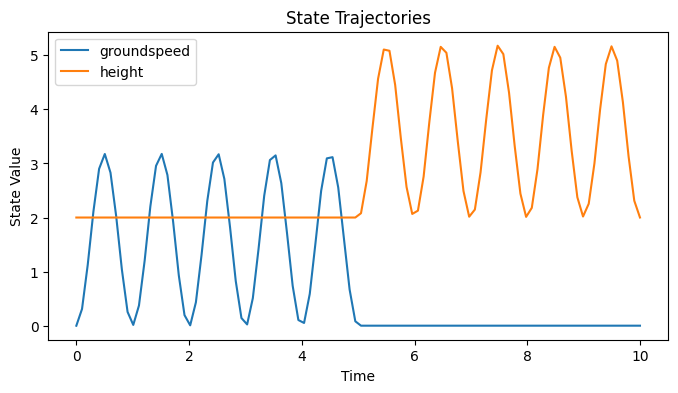

In [2]:
x0 = np.array([[0], [2]])
T = np.linspace(0,10,100)
X_df = sys.simulate_states(x0=x0, t_vector=T, 
                           override_system_Q=False,
                           override_system_f=sinusoidal_control_input_with_params(amplitude=10,frequency=1,t_switch=5),
                           output_df=True)
X_df.plot(title="State Trajectories", xlabel="Time", ylabel="State Value", figsize=(8, 4))

Using the previously simulated state trajectories, we can now generate the corresponding sensor measurements from the monocamera. The optic flow sensor observes only the ratio of groundspeed to height. Note how the sensor can give **no** information about the height of the system while the monocamera is vertically driven. 

<Axes: title={'center': 'Measureument Trajectory'}, xlabel='Time', ylabel='Value'>

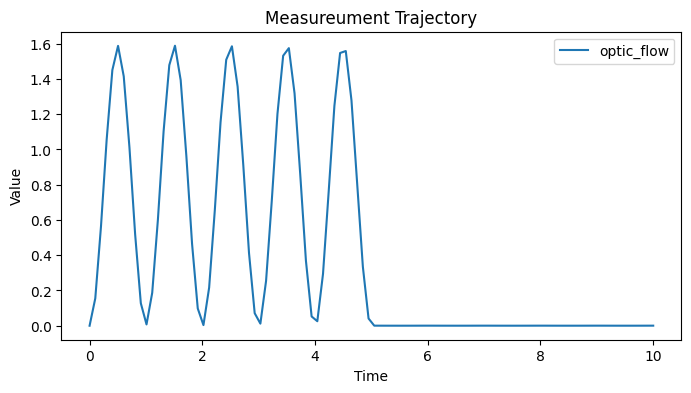

In [3]:
Y_df = sys.simulate_measurements(X_df=X_df, override_system_R=False,input_df=True,output_df =True)
Y_df.plot(title="Measureument Trajectory", xlabel="Time", ylabel="Value", figsize=(8, 4))

We can visualize the measurement trajecoctory superimposed upon the state trajectories to get an intuitive feel for the entire dynamical system. 

<Axes: title={'center': 'True vs Measured State Values '}, xlabel='time', ylabel='Values'>

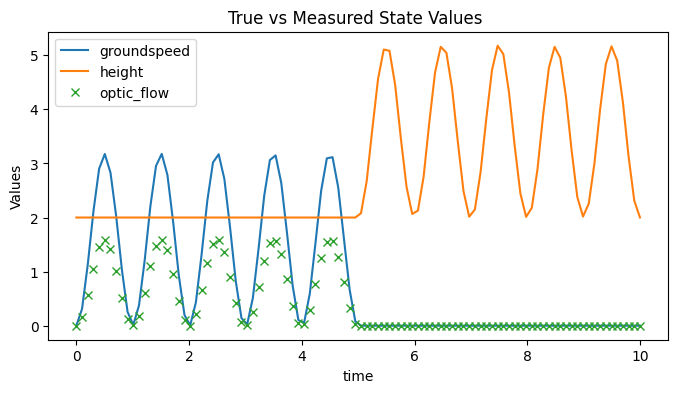

In [4]:
ax = X_df.plot(
      title="True vs Measured State Values ", xlabel="Time", ylabel="Values", figsize=(8, 4)
  )
ax.grid(True)  
Y_df.plot(ax=ax, style="x")

## Investigating Observability
With the `Observer` class, we can now investigate the observability structure of the monocamera system. 

In [5]:
from pykal.control_system.observer import Observer
obs = Observer(sys)

We first compute the empirical observability Gramian (constructed from the empirical observability matrix). The matrix is full rank, so the system is observable. Further, the CN is low. 

In [6]:
from pykal.utils import compute
W = compute.Observability.grammian(obs.sys,x0=x0,t_vector=T)
W

array([[57.55887254, -9.04886093],
       [-9.04886093, 11.78204456]])

In [7]:
eigvals, eigvec = compute.Matrix.eigenvalues_and_eigenvectors_of_symmetric_matrix(W)

In [8]:
compute.Matrix.condition_number_from_eigenvalues(eigvals)

np.float64(5.893942467881152)

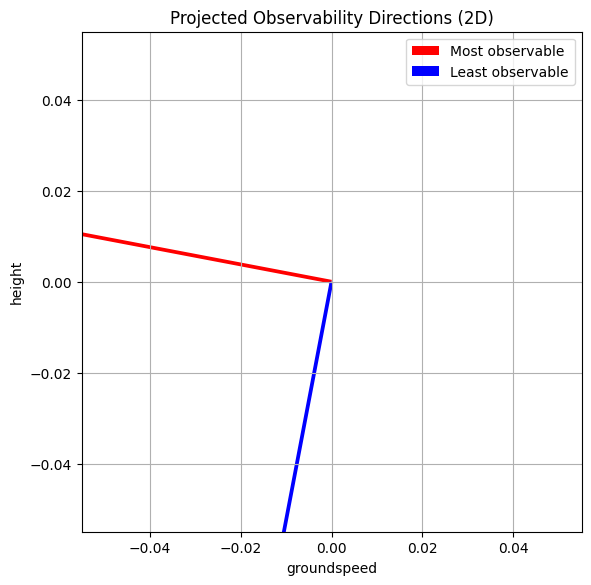

In [9]:
compute.Observability.plot_observability_directions_from_eigenpairs(eigvals,eigvec,state_names=obs.sys.state_names)

Interesting. But now supposed we only restricted ourselves to the observability of the vertical control portion. 

In [10]:
W = compute.Observability.grammian(obs.sys,x0=x0,t_vector=T[50:100])
W

array([[5.80219029, 0.        ],
       [0.        , 0.        ]])

In [11]:
eigvals, eigvec = compute.Matrix.eigenvalues_and_eigenvectors_of_symmetric_matrix(W)

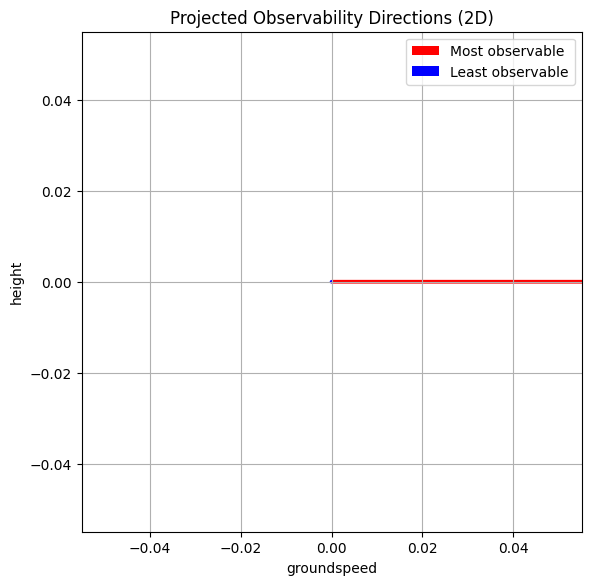

In [12]:
compute.Observability.plot_observability_directions_from_eigenpairs(eigvals,eigvec,state_names=obs.sys.state_names)

Groundspeed is observable, but height is not! We can also use the nullspace method to quantify this.

In [13]:
compute.Observability.of_states_from_grammian_nullspace(sys=obs.sys,W=W,output_sr=True)

groundspeed    1.0
height         0.0
Name: Observability Index, dtype: float64

Lets now look over the whole trajectory, split into the two different driving modes.

In [14]:
state_observability_over_time = compute.Observability.of_states_over_time_from_grammian_via_callable(sys=obs.sys,
                                                                                                     x0=x0,
                                                                                                     grammian_to_scores_func=compute.Observability.of_states_from_grammian_nullspace,
                                                                                                     t_vector=T,
                                                                                                    divide_time_into_k_windows=50,
                                                                                                    output_df=True)

<Axes: xlabel='time'>

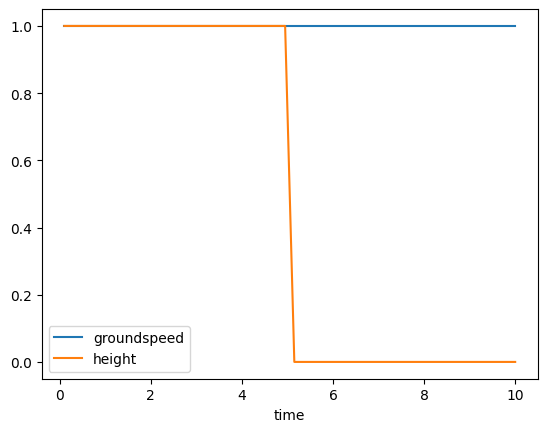

In [15]:
state_observability_over_time.plot()

We now try another method, stochastic observability

In [30]:
def test_Q(noise_in_groundspeed: float = 0.1, noise_in_height: float = 0.1):
    def Q() -> NDArray:
        return np.diag([noise_in_groundspeed, noise_in_height])
    
    return Q

def test_R(noise_in_optic_flow: float = 0.1):
    def R() -> NDArray:
        return np.diag([noise_in_optic_flow])
    
    return R
X_df = sys.simulate_states(x0=x0, t_vector=T,override_system_Q=test_Q(),output_df=True)
Y_df = sys.simulate_measurements(X_df=X_df,input_df=True,override_system_R=test_R(),output_df =True)

In [31]:
import pandas as pd
P0 = np.eye(2) * 0.1
obs = Observer(sys)
x_est = x0 + np.random.multivariate_normal(mean=[0, 0], cov=P0).reshape(2,1)

def nullspace_beta(tk: float) -> NDArray:
    """
    Return the observability-based beta vector at time closest to `tk`.
    """
    index_array = state_observability_over_time.index.to_numpy()
    closest_idx = np.abs(index_array - tk).argmin()
    closest_time = index_array[closest_idx]
    row = state_observability_over_time.loc[closest_time]
    return row.to_numpy()
beta_log = pd.DataFrame(columns=state_names)
X_est_df, P_est_sr = obs.ekf.run(x0=x_est,P0=P0,Y_df=Y_df, input_df=True, output_df=True,
                                 override_update=obs.ekf.override_update_partial(beta=nullspace_beta,beta_log=beta_log))

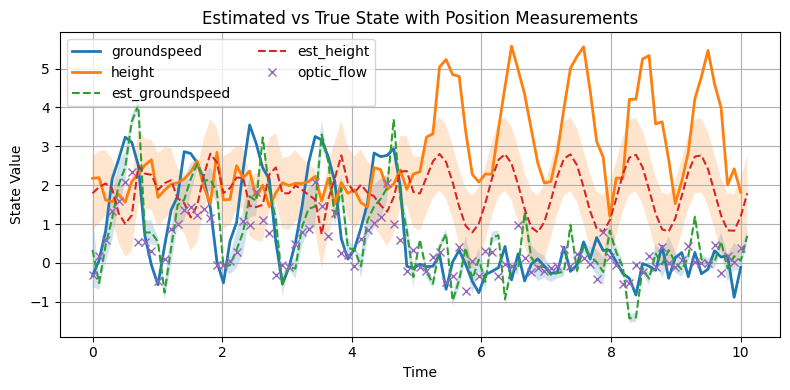

In [32]:
fig, ax = plt.subplots(figsize=(8, 4))

# Plot true states
X_df.plot(ax=ax, linewidth=2)

# Plot estimates (dashed)
X_est_df.plot(ax=ax, linestyle="--")

# Plot measurements
Y_df.plot(ax=ax, style="x")

# Add ±3σ confidence intervals for each state
for i, col in enumerate(X_est_df.columns):
    mean = X_est_df[col]
    std = np.sqrt([P[i, i] for P in P_est_sr])  # assumes P_est is a list of (n, n) cov matrices
    ax.fill_between(
        X_est_df.index,
        mean - 3 * std,
        mean + 3 * std,
        alpha=0.2,
    )

ax.set_title("Estimated vs True State with Position Measurements")
ax.set_xlabel("Time")
ax.set_ylabel("State Value")
ax.grid(True)
ax.legend(ncol=2)
plt.tight_layout()
plt.show()


<Axes: >

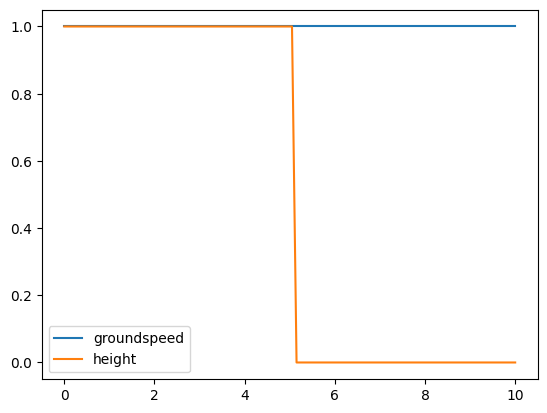

In [33]:
beta_log.plot()